In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import platform
import importlib
import netCDF4
import multiprocessing as mp
import itertools

user_name = input("Your home folder's user name?")

if platform.system() == 'Darwin':  # macOS
    base_FP = f'/Users/{user_name}/data'
    cpuserver_data_FP = f'/Users/{user_name}/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = f'/home/{user_name}/data'
    cpuserver_data_FP = f'/home/{user_name}/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
print(base_FP, cpuserver_data_FP)
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import HydroAI.HLS as hHLS
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
importlib.reload(hHLS);
importlib.reload(hPlot);
importlib.reload(hData);
importlib.reload(hGrid);

Your home folder's user name? subin


/home/subin/data /home/subin/cpuserver_data


In [2]:
def find_study_dates(root_folder, regex_date='[0-9][0-9][0-9][0-9].[0-9][0-9].[0-9][0-9]'):
    dates = []
    folder_pattern = os.path.join(root_folder, regex_date)
    folders = glob.glob(folder_pattern)
    folders = sorted(folders)
    for folder in folders:
        date_pattern = r'\d{4}\.\d{2}\.\d{2}'
        match = re.search(date_pattern, folder).group(0)
        dates.append(match)
    
    return np.array(dates)

In [3]:
#bound = [125.7, 129.7, 33.9, 38.8] # entire Korea
#bound = [126.73, 126.95, 35.17, 35.37] # Around GIST in Gwangju 
bound = [126.63, 127.03, 35.04, 35.28] # entire Gwangju 

target_projection = 'eqd_001' 
domain_lon, domain_lat = hGrid.generate_lon_lat_eqdgrid(0.01*0.03, bounds=bound)
print(np.shape(domain_lon))

#print(domain_lat[:,0])
#print(domain_lon[0])

(800, 1333)


In [4]:
def combined_crop_lon_lat(lon, lat, bounds):
    lon_crop = (lon > bounds[0]) & (lon < bounds[1])
    lat_crop = (lat > bounds[2]) & (lat < bounds[3])
    combined_crop = lat_crop & lon_crop
    row_indices, col_indices = np.where(combined_crop)
    
    min_row, max_row = row_indices.min(), row_indices.max()
    min_col, max_col = col_indices.min(), col_indices.max()

    return min_row, max_row, min_col, max_col

In [5]:
def parallel_func(year):
    var_list = ['coastal', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'cirrus', 'tir1', 'tir2', 'qa']
    
    #for year in year_list:
    study_dates = find_study_dates(f'{cpuserver_data_FP}/HLS/Korea/L30/{year}')

    m, n = np.shape(domain_lat)
    coastal_total = np.full((m, n, len(study_dates)), np.nan)
    blue_total = np.full((m, n, len(study_dates)), np.nan)
    green_total = np.full((m, n, len(study_dates)), np.nan)
    red_total = np.full((m, n, len(study_dates)), np.nan)
    nir_total = np.full((m, n, len(study_dates)), np.nan)
    swir1_total = np.full((m, n, len(study_dates)), np.nan)
    swir2_total = np.full((m, n, len(study_dates)), np.nan)
    cirrus_total = np.full((m, n, len(study_dates)), np.nan)
    tir1_total = np.full((m, n, len(study_dates)), np.nan)
    tir2_total = np.full((m, n, len(study_dates)), np.nan)
    qa_total = np.full((m, n, len(study_dates)), np.nan)
        
    for i, target_date in enumerate(study_dates):
        base_folder = f'{cpuserver_data_FP}/HLS/Korea/L30/{target_date[:4]}/{target_date}/merged'
        s2_reader = hHLS.SentinelBandReader(base_folder, product='L30')

        try:
            var_dict = {}
            for var in var_list:
                data = s2_reader[var]
                lons, lats  = s2_reader.get_lat_lon_arrays(var)
    
                # Find the bounding box & indices
                min_row, max_row, min_col, max_col = combined_crop_lon_lat(lons, lats, bounds=bound)
                
                # Crop lat, lon, data
                cropped_lat = lats[min_row:max_row+1, min_col:max_col+1]
                cropped_lon = lons[min_row:max_row+1, min_col:max_col+1]
                cropped_data = data[min_row:max_row+1, min_col:max_col+1]
    
                # Find the cropped domain lon, lat
                min_row, max_row, min_col, max_col = combined_crop_lon_lat(domain_lon, domain_lat, bounds=bound)
    
                # Crop lat, lon, data
                cropped_domain_lat = domain_lat[min_row:max_row+1, min_col:max_col+1]
                cropped_domain_lon = domain_lon[min_row:max_row+1, min_col:max_col+1]
                
                cropped_data = hData.Resampling(cropped_domain_lon, cropped_domain_lat, cropped_lon, cropped_lat, cropped_data, 
                                                sampling_method='nearest', mag_factor=3)           
                var_dict[var] = cropped_data            

            coastal_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['coastal']
            blue_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['blue']
            green_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['green']
            red_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['red']
            nir_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['nir']
            swir1_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['swir1']
            swir2_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['swir2']
            cirrus_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['cirrus']
            tir1_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['tir1']
            tir2_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['tir2']
            qa_total[min_row:max_row+1, min_col:max_col+1, i] = var_dict['qa']
        
        except ValueError as e:
            print(year, target_date, var, e)

    study_dates = np.char.replace(study_dates, '.', '').astype(int) # str(yyyy.mm.dd) -> int(yyyymmdd)    
    
    nc_file_name = f'{cpuserver_data_FP}/HLS/Korea/UHI_project_L30/HLS_{year}_GJ.nc'

    hData.create_netcdf_file(
        nc_file=nc_file_name, 
        latitude=domain_lat, 
        longitude=domain_lon,
        dates=study_dates,
        coastal=coastal_total,
        blue=blue_total,
        green=green_total,
        red=red_total,
        nir=nir_total,
        swir1=swir1_total,
        swir2=swir2_total,
        cirrus=cirrus_total,
        tir1=tir1_total,
        tir2=tir2_total,
        qa=qa_total
    )

In [6]:
year_list = list(range(2013, 2024 + 1))

# Parallel running
pool = mp.Pool(20)
pool.map(parallel_func, year_list)

2015 2015.02.28 coastal zero-size array to reduction operation minimum which has no identity
2015 2015.06.11 coastal zero-size array to reduction operation minimum which has no identity
2015 2015.07.13 coastal zero-size array to reduction operation minimum which has no identity
2015 2015.07.20 coastal zero-size array to reduction operation minimum which has no identity
2015 2015.07.22 coastal zero-size array to reduction operation minimum which has no identity
2015 2015.12.20 coastal zero-size array to reduction operation minimum which has no identity
NetCDF file /home/subin/cpuserver_data/HLS/Korea/UHI_project_L30/HLS_2015_GJ.nc created successfully.


[None]

In [35]:
year = 2024
nc_file_name = f'{cpuserver_data_FP}/HLS/Korea/UHI_project_L30/HLS_{year}_GJ.nc' 
nc_data   = netCDF4.Dataset(nc_file_name)
dates_int = nc_data.variables['dates'][:].data
tir1    = nc_data.variables['tir1'][:].data
red     = nc_data.variables['red'][:].data
nir     = nc_data.variables['nir'][:].data
swir1   = nc_data.variables['swir1'][:].data
nc_data.close()

In [36]:
print(dates_int)
dates = [f"{str(x)[:4]}.{str(x)[4:6]}.{str(x)[6:]}" for x in dates_int]
print(dates)

[20240102 20240103 20240104 20240110 20240111 20240112 20240118 20240119
 20240126 20240127 20240128 20240203 20240204 20240211 20240212 20240213
 20240219 20240227 20240228 20240306 20240307 20240308 20240314 20240315
 20240316 20240322 20240323 20240324 20240330 20240331 20240401 20240407
 20240408 20240409 20240416 20240417 20240423 20240424 20240425 20240501
 20240502 20240503 20240509 20240510 20240511 20240517 20240518 20240519]
['2024.01.02', '2024.01.03', '2024.01.04', '2024.01.10', '2024.01.11', '2024.01.12', '2024.01.18', '2024.01.19', '2024.01.26', '2024.01.27', '2024.01.28', '2024.02.03', '2024.02.04', '2024.02.11', '2024.02.12', '2024.02.13', '2024.02.19', '2024.02.27', '2024.02.28', '2024.03.06', '2024.03.07', '2024.03.08', '2024.03.14', '2024.03.15', '2024.03.16', '2024.03.22', '2024.03.23', '2024.03.24', '2024.03.30', '2024.03.31', '2024.04.01', '2024.04.07', '2024.04.08', '2024.04.09', '2024.04.16', '2024.04.17', '2024.04.23', '2024.04.24', '2024.04.25', '2024.05.01', 

In [37]:
np.shape(tir1)

(800, 1333, 48)

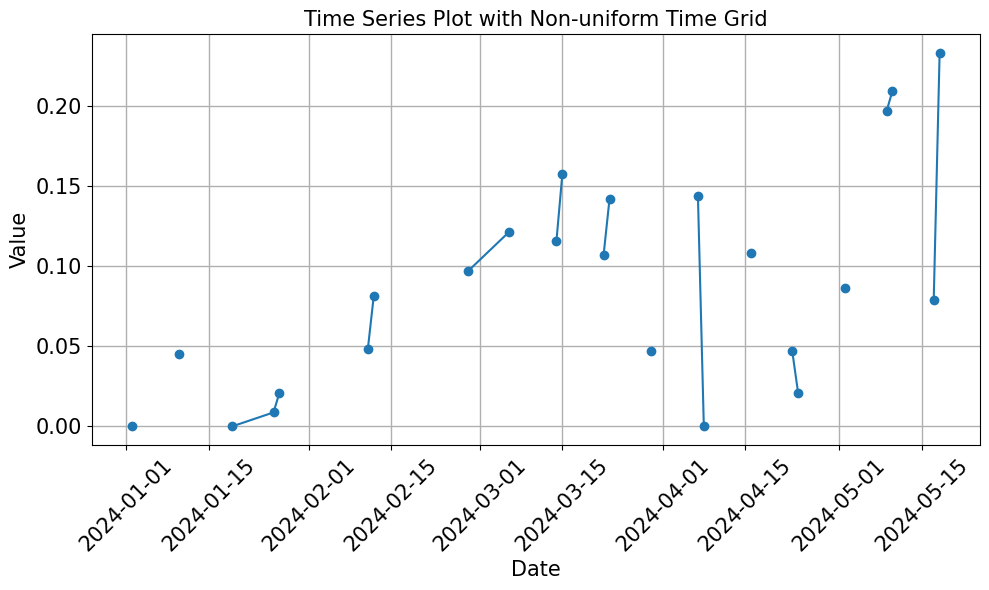

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Dataset
#dates = ['2013.04.11', '2013.04.25', '2013.04.27', '2013.05.11', '2013.05.13', '2013.05.20', '2013.06.05', '2013.06.21', '2013.06.28', '2013.06.30']
values = tir1[300, 300, :]

# Convert date strings to datetime objects
dates = pd.to_datetime(dates, format='%Y.%m.%d')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot with Non-uniform Time Grid')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
